# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
! pip install pyspark_dist_explore

In [2]:
# import the necessary libraries
import datetime
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, StringType, BooleanType, StructType, StructField
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg, max, count, when, desc, asc, udf, col, isnan, sort_array, format_string
from pyspark.ml.linalg import Vectors
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes, LogisticRegression
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression
from pyspark_dist_explore import hist
from pyspark.sql import Window
from pyspark.sql import SQLContext
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName('Sparkify Project') \
    .getOrCreate()
    


In [4]:
#load the dataset, clean dataset and perform count operation for before and after cleaning
sparkify_event_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_event_data)
df_cleaned = df.dropna(how = 'any', subset = ['gender'])
df.count(), df_cleaned.count()

(286500, 278154)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [5]:
#extract gender, check gender and fill the column with 1's and 0's
gender_df = df_cleaned.select('userId', 'gender').distinct()\
                        .withColumn('check_male', (df_cleaned.gender == 'M').cast(IntegerType()))\
                        .sort('userId')\
                        .select('userId', 'check_male') 

In [6]:
#display gender
gender_df.show()

+------+----------+
|userId|check_male|
+------+----------+
|    10|         1|
|   100|         1|
|100001|         0|
|100002|         0|
|100003|         0|
|100004|         0|
|100005|         1|
|100006|         0|
|100007|         0|
|100008|         0|
|100009|         1|
|100010|         0|
|100011|         1|
|100012|         1|
|100013|         0|
|100014|         1|
|100015|         0|
|100016|         1|
|100017|         1|
|100018|         1|
+------+----------+
only showing top 20 rows



In [7]:
#extract pages, remove unwanted pages clean and drop duplicates  
pages = [row[0] for row in df_cleaned.select('page').distinct().collect()]
pages.remove('Cancel')
pages.remove('Cancellation Confirmation')
print(pages)
windowval = Window.partitionBy('userId')
page_df = df_cleaned
for page in pages:
    page_df = page_df.withColumn(page.replace(' ', ''), Fsum((df_cleaned.page == page).cast(IntegerType())).over(windowval))
other_pages = []
for page in pages:
    other_pages.append(page.replace(' ', ''))
page_df = page_df.select('userId', *other_pages).dropDuplicates().sort('userId')


['Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']


In [8]:
#extract information about songs like songs count in a session
songs_df = df_cleaned.select('userId','sessionId','itemInSession').groupby('userId','sessionId').agg({'itemInSession':'max'}) \
    .groupby('userId').agg(Fsum('max(itemInSession)'), avg('max(itemInSession)'), count('sessionId')) \
    .withColumnRenamed('avg(max(itemInSession))','songs_session_a_v') \
    .withColumnRenamed('sum(max(itemInSession))', 'songs_c') \
    .withColumnRenamed('count(sessionId)', 'sessions_c') \
    .sort('userId')

In [9]:
#display songs
songs_df.show(5)

+------+-------+-----------------+----------+
|userId|songs_c|songs_session_a_v|sessions_c|
+------+-------+-----------------+----------+
|    10|    813|            135.5|         6|
|   100|   3263|93.22857142857143|        35|
|100001|    197|            49.25|         4|
|100002|    216|             54.0|         4|
|100003|     82|             41.0|         2|
+------+-------+-----------------+----------+
only showing top 5 rows



In [10]:
#extract lifetime of user from the timestamp he got in registration 
lifetime_df = df_cleaned.groupby('userId').agg({'registration':'min', 'ts':'max'})\
    .withColumn('lifetime_in_days', (col('max(ts)') - col('min(registration)'))/1000/60/60/24)\
    .select('userId', 'lifetime_in_days').sort('userId')

In [11]:
#display lifetime in days grouped by user
lifetime_df.show(5)

+------+------------------+
|userId|  lifetime_in_days|
+------+------------------+
|    10| 51.76265046296296|
|   100| 64.87377314814815|
|100001| 44.80021990740741|
|100002|160.47207175925925|
|100003|22.748113425925926|
+------+------------------+
only showing top 5 rows



In [12]:
#select three status as a list
st_list = [str(row[0]) for row in df_cleaned.select('status').distinct().collect()]
print(st_list)

['307', '404', '200']


In [13]:
#take the status extracted as columns
st_df = df_cleaned
for status in st_list:
    st_df = st_df.withColumn('status_'+status, Fsum((df_cleaned.status == status).cast(IntegerType())). over(windowval))
st_df = st_df.select('userId', 'status_307', 'status_404', 'status_200').distinct().sort('userId')

In [14]:
#display distinct status
st_df.show(5)

+------+----------+----------+----------+
|userId|status_307|status_404|status_200|
+------+----------+----------+----------+
|    10|        65|         0|       730|
|   100|       266|         3|      2945|
|100001|        20|         1|       166|
|100002|         7|         0|       211|
|100003|         7|         0|        71|
+------+----------+----------+----------+
only showing top 5 rows



In [15]:
#Take a list, function taken to loop through list, give 1 in column if useragent has list value
brow = ['Macintosh', 'Windows NT', 'X11', 'iPad', 'iPhone', 'MSIE']
u_a_df = df_cleaned
@udf
def map_ua(row_val):
    for val in brow:
        if row_val.find(val) > -1:
            return(val)
u_a_df = u_a_df.select('userId', 'userAgent').distinct() \
    .withColumn('userAgent_sh', map_ua(col('userAgent'))).select('userId', 'userAgent_sh')
for val in brow:
    u_a_df = u_a_df.withColumn(val.replace(' ', ''), (col('userAgent_sh') == val).cast(IntegerType()))
other_brow = []
#removing spaces in list names
for val in brow:
    other_brow.append(val.replace(' ', ''))
u_a_df = u_a_df.select('userId', *other_brow)
    

In [16]:
#display columns extracted in previous cell
%%time
print('started', datetime.datetime.now())
u_a_df.show(5)
print('ended', datetime.datetime.now())

started 2019-11-13 09:00:08.971537
+------+---------+---------+---+----+------+----+
|userId|Macintosh|WindowsNT|X11|iPad|iPhone|MSIE|
+------+---------+---------+---+----+------+----+
|200021|        1|        0|  0|   0|     0|   0|
|   156|        0|        1|  0|   0|     0|   0|
|100010|        0|        0|  0|   0|     1|   0|
|     7|        0|        1|  0|   0|     0|   0|
|   117|        0|        1|  0|   0|     0|   0|
+------+---------+---------+---+----+------+----+
only showing top 5 rows

ended 2019-11-13 09:00:12.406822
CPU times: user 4.76 ms, sys: 0 ns, total: 4.76 ms
Wall time: 3.44 s


In [17]:
#extract the level of user, if paid get maximum user level paid  and fil with 1
lev_df = df_cleaned.select('userId', 'level').distinct() \
    .withColumn('u_lev_paid', (df_cleaned.level == 'paid').cast(IntegerType())).groupby('userId') \
    .agg({'u_lev_paid':'max'}).select('userId', 'max(u_lev_paid)') \
    .withColumnRenamed('max(u_lev_paid)', 'paid_success').sort('userId')

In [18]:
#dispay user level
%%time
lev_df.show(5)

+------+------------+
|userId|paid_success|
+------+------------+
|    10|           1|
|   100|           1|
|100001|           0|
|100002|           1|
|100003|           0|
+------+------------+
only showing top 5 rows

CPU times: user 2.2 ms, sys: 324 µs, total: 2.52 ms
Wall time: 5.88 s


In [19]:
#extract labels for user, label 1 for cancellation confirmation to churn users
cancel_event_tag = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
lab_df = df_cleaned.withColumn('cancel_event', cancel_event_tag(df_cleaned['page']))
lab_df = lab_df.withColumn('label', Fsum('cancel_event').over(windowval))
lab_df = lab_df.select('userId', 'label').dropDuplicates().sort('userId')

In [20]:
lab_df.select('label').distinct().show()
lab_df.show(5)

+-----+
|label|
+-----+
|    0|
|    1|
+-----+

+------+-----+
|userId|label|
+------+-----+
|    10|    0|
|   100|    0|
|100001|    1|
|100002|    0|
|100003|    1|
+------+-----+
only showing top 5 rows



In [21]:
#join all the extracted features and form a dataset
filledup_df = lab_df.select('userId', 'label').dropDuplicates().join(gender_df, 'userId').join(lev_df, 'userId') \
    .join(lifetime_df, 'userId').join(page_df, 'userId').join(songs_df, 'userId').join(st_df, 'userId').dropDuplicates() \
    .sort('userId')

In [22]:
#display the joined dataset
%%time
print('started', datetime.datetime.now())
filledup_df.show(5)
print('ended', datetime.datetime.now())

started 2019-11-13 09:00:39.493345
+------+-----+----------+------------+------------------+---------------+----------+----+---------+----------+------+------------+-----+--------+-------------+---------+--------+--------+----+-------+-----+-------------+-------+-----------------+----------+----------+----------+----------+
|userId|label|check_male|paid_success|  lifetime_in_days|SubmitDowngrade|ThumbsDown|Home|Downgrade|RollAdvert|Logout|SaveSettings|About|Settings|AddtoPlaylist|AddFriend|NextSong|ThumbsUp|Help|Upgrade|Error|SubmitUpgrade|songs_c|songs_session_a_v|sessions_c|status_307|status_404|status_200|
+------+-----+----------+------------+------------------+---------------+----------+----+---------+----------+------+------------+-----+--------+-------------+---------+--------+--------+----+-------+-----+-------------+-------+-----------------+----------+----------+----------+----------+
|    10|    0|         1|           1| 51.76265046296296|              0|         4|  30|   

In [23]:
#convert to pandas dataframe
filledup_df.toPandas().head()

,userId,label,check_male,paid_success,lifetime_in_days,SubmitDowngrade,ThumbsDown,Home,Downgrade,RollAdvert,...,Help,Upgrade,Error,SubmitUpgrade,songs_c,songs_session_a_v,sessions_c,status_307,status_404,status_200
0,10,0,1,1,51.762650,0,4,30,7,1,...,1,0,0,0,813,135.500000,6,65,0,730
1,100,0,1,1,64.873773,1,27,105,30,25,...,18,1,3,1,3263,93.228571,35,266,3,2945
2,100001,1,0,0,44.800220,0,2,11,0,14,...,1,2,1,0,197,49.250000,4,20,1,166
3,100002,0,0,1,160.472072,0,0,6,2,3,...,0,0,0,0,216,54.000000,4,7,0,211
4,100003,1,0,0,22.748113,0,0,7,0,9,...,1,0,0,0,82,41.000000,2,7,0,71


In [24]:
#pull out names of columns as features list, remove userid and label
from pyspark.ml.feature import StringIndexer,VectorAssembler,OneHotEncoder
features = list(filledup_df.columns)
print(features)
features.remove('userId')
features.remove('label')
print(features)

['userId', 'label', 'check_male', 'paid_success', 'lifetime_in_days', 'SubmitDowngrade', 'ThumbsDown', 'Home', 'Downgrade', 'RollAdvert', 'Logout', 'SaveSettings', 'About', 'Settings', 'AddtoPlaylist', 'AddFriend', 'NextSong', 'ThumbsUp', 'Help', 'Upgrade', 'Error', 'SubmitUpgrade', 'songs_c', 'songs_session_a_v', 'sessions_c', 'status_307', 'status_404', 'status_200']
['check_male', 'paid_success', 'lifetime_in_days', 'SubmitDowngrade', 'ThumbsDown', 'Home', 'Downgrade', 'RollAdvert', 'Logout', 'SaveSettings', 'About', 'Settings', 'AddtoPlaylist', 'AddFriend', 'NextSong', 'ThumbsUp', 'Help', 'Upgrade', 'Error', 'SubmitUpgrade', 'songs_c', 'songs_session_a_v', 'sessions_c', 'status_307', 'status_404', 'status_200']


In [25]:
#drop nans in gender column
df_cleaned = df.dropna(how='any', subset=['gender'])
df_cleaned.show(2)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   Canada|   200|1538352180000|"Moz

In [26]:
def new_df(df):
    gender_df = df_cleaned.select('userId', 'gender').distinct()\
                     .withColumn('check_male', (df_cleaned.gender == 'M').cast(IntegerType()))\
                     .sort('userId')\
                     .select('userId', 'check_male')
    
    print('pages...')
    pages = [row(0) for row in df_cleaned.select('page').distinct().collect()]
    #pages.remove('Cancel')
    #pages.remove('Cancellation Confirmation')
    winndowval = Window.partitionBy('userId')
    page_df = df_cleaned
    for page in pages:
        page_df = page_df.withColumn(page.replace(' ', ''), Fsum((df_cleaned.page == page).cast(IntegerType())).over(windowval))
    other_pages = []
    for page in pages:
        other_pages.append(page.replace(' ', ''))
    page_df = page_df.select('userId', *other_pages).dropDuplicates().sort('userId')
    
    print('item...')
    songs_df = df_cleaned.select('userId','sessionId','itemInSession') \
                            .groupby('userId','sessionId') \
                            .agg({'itemInSession':'max'}) \
                            .groupby('userId') \
                            .agg( Fsum('max(itemInSession)'), avg('max(itemInSession)'), count('sessionId') ) \
                            .withColumnRenamed('avg(max(itemInSession))','songs_session_a_v') \
                            .withColumnRenamed('sum(max(itemInSession))', 'songs_c') \
                            .withColumnRenamed('count(sessionId)', 'sessions_c') \
                            .sort('userId')
    print('lifetime...')
    lifetime_df = df_cleaned.groupby('userId') \
                  .agg({'registration':'min', 'ts':'max'})\
                  .withColumn('lifetime_in_days', (col('max(ts)')-col('min(registration)'))/1000/60/60/24)\
                  .select('userId', 'lifetime_in_days') \
                  .sort('userId')
    print('status...')
    st_list = [str(row[0]) for row in df_cleaned.select('status').distinct().collect()]
    st_df = df_cleaned
    for status in st_list:
        st_df = st_df.withColumn('status_'+status, Fsum((df_cleaned.status == status).cast(IntegerType())).over(windowval))
    st_df = st_df.select('userId', 'status_307', 'status_404', 'status_200').distinct().sort('userId')
    print('level...')
    lev_df = df_cleaned.select('userId', 'level').distinct() \
                      .withColumn('u_lev_paid', (df_cleaned.level == 'paid').cast(IntegerType())) \
                      .groupby('userId') \
                      .agg({'u_lev_paid':'max'}) \
                      .select('userId', 'max(u_lev_paid)') \
                      .withColumnRenamed('max(u_lev_paid)', 'paid_success') \
                      .sort('userId')
    print('label...')
    phase_ev = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
    lab_df = df_cleaned.withColumn('phase', phase_ev(df_cleaned['page']))
    lab_df = lab_df.withColumn('label', Fsum('phase').over(windowval))
    lab_df = lab_df.select('userId', 'label').dropDuplicates().sort('userId')
    print('joining...')
    features_df = lab_df.select('userId', 'label').dropDuplicates().join(gender_df, 'userId').join(lev_df, 'userId') \
        .join(lifetime_df, 'userId').join(page_df, 'userId').join(songs_df, 'userId').join(st_df, 'userId').dropDuplicates() \
        .sort('userId')
    return(features_df)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [27]:
#count the number in pandas dataframe
filledup_df.count()

225

In [28]:
#use vector assembler to transform
%%time
assembler = VectorAssembler(inputCols=features, outputCol='features_vector')
filledup_df = assembler.transform(filledup_df)

CPU times: user 7.45 ms, sys: 1.38 ms, total: 8.84 ms
Wall time: 360 ms


In [29]:
#show two rows in dataframe
filledup_df.show(2)

+------+-----+----------+------------+-----------------+---------------+----------+----+---------+----------+------+------------+-----+--------+-------------+---------+--------+--------+----+-------+-----+-------------+-------+-----------------+----------+----------+----------+----------+--------------------+
|userId|label|check_male|paid_success| lifetime_in_days|SubmitDowngrade|ThumbsDown|Home|Downgrade|RollAdvert|Logout|SaveSettings|About|Settings|AddtoPlaylist|AddFriend|NextSong|ThumbsUp|Help|Upgrade|Error|SubmitUpgrade|songs_c|songs_session_a_v|sessions_c|status_307|status_404|status_200|     features_vector|
+------+-----+----------+------------+-----------------+---------------+----------+----+---------+----------+------+------------+-----+--------+-------------+---------+--------+--------+----+-------+-----+-------------+-------+-----------------+----------+----------+----------+----------+--------------------+
|    10|    0|         1|           1|51.76265046296296|           

In [30]:
#display column names as features
print(features)

['check_male', 'paid_success', 'lifetime_in_days', 'SubmitDowngrade', 'ThumbsDown', 'Home', 'Downgrade', 'RollAdvert', 'Logout', 'SaveSettings', 'About', 'Settings', 'AddtoPlaylist', 'AddFriend', 'NextSong', 'ThumbsUp', 'Help', 'Upgrade', 'Error', 'SubmitUpgrade', 'songs_c', 'songs_session_a_v', 'sessions_c', 'status_307', 'status_404', 'status_200']


In [31]:
#take standard scaler fit and transform
%%time
standardScaler = StandardScaler(inputCol='features_vector', outputCol='features_scaled')
scaler = standardScaler.fit(filledup_df)
scaled_df = scaler.transform(filledup_df)

CPU times: user 115 ms, sys: 30.1 ms, total: 145 ms
Wall time: 1min 19s


In [32]:
#split the transformed output of standard scaler into train and test 
train, test = scaled_df.randomSplit([0.8, 0.2], seed=42)

In [38]:
def eva_metrics(predictionAndLabels):
    '''
    function to evaluate metrics using MultiClasscassificationEvaluator
    INPUT: predicted output of the different classifiers(naive_bayes, random forest)
    OUTPUT: metrics like F1-score, accuracy, precision, recall
    '''
    met_f1 = MulticlassClassificationEvaluator(metricName='f1')
    met_acc = MulticlassClassificationEvaluator(metricName='accuracy')
    met_pre = MulticlassClassificationEvaluator(metricName='weightedPrecision')
    met_rec = MulticlassClassificationEvaluator(metricName='weightedRecall')
    f1_sc = met_f1.evaluate(predictionAndLabels.select(col('label'), col('prediction')))
    acc_sc = met_acc.evaluate(predictionAndLabels.select(col('label'), col('prediction')))
    pre_sc = met_pre.evaluate(predictionAndLabels.select(col('label'), col('prediction')))
    rec_sc = met_rec.evaluate(predictionAndLabels.select(col('label'), col('prediction')))
    print('F1_Score: ', f1_sc)
    print('Accuracy: ', acc_sc)
    print('Precision: ', pre_sc)
    print('Recall: ', rec_sc)
    

In [41]:
#using naive bayes classifier
%%time
nav_bay = NaiveBayes(featuresCol='features_scaled',labelCol = 'label')
nav_bay_model = nav_bay.fit(train)
nav_bay_pred = nav_bay_model.transform(test)

CPU times: user 267 ms, sys: 109 ms, total: 376 ms
Wall time: 4min 2s


In [42]:
#display metrics of naive bayes
%%time
print('started', datetime.datetime.now)
eva_metrics(nav_bay_pred)

started <built-in method now of type object at 0x7f17281c7120>
F1_Score:  0.7416149068322981
Accuracy:  0.7608695652173914
Precision:  0.7288043478260868
Recall:  0.7608695652173912
CPU times: user 520 ms, sys: 235 ms, total: 755 ms
Wall time: 6min 2s


In [46]:
#using random forest classifier
#I have seected these classifiers as they gave me good outputs in previous projects also
ran_for = RandomForestClassifier(featuresCol = 'features_scaled', labelCol = 'label', numTrees = 15, seed=42)
ran_for_model = ran_for.fit(train)
ran_for_pred = ran_for_model.transform(test)

In [47]:
#display random forest metrics
%%time
print('started', datetime.datetime.now)
eva_metrics(ran_for_pred)

started <built-in method now of type object at 0x7f17281c7120>
F1_Score:  0.7571269310399745
Accuracy:  0.782608695652174
Precision:  0.7452810180275715
Recall:  0.7826086956521738
CPU times: user 456 ms, sys: 286 ms, total: 742 ms
Wall time: 6min 3s


In [51]:
#tuning feature parameters for best metrics
#here I have taken less parameters and their value also as less keeping in view memory and time problems
pa_grid = ParamGridBuilder().addGrid(ran_for.maxDepth,[2, 4]).addGrid(ran_for.maxBins,[5, 10]).build()

cv = CrossValidator(estimator=ran_for, estimatorParamMaps=pa_grid, 
                    evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                    numFolds = 3)
                    

In [52]:
#fit the above into part of dataset
%%time
print('started', datetime.datetime.now)
cv_tune = cv.fit(train)
print('ended', datetime.datetime.now)

started <built-in method now of type object at 0x7f17281c7120>
ended <built-in method now of type object at 0x7f17281c7120>
CPU times: user 3.64 s, sys: 1.39 s, total: 5.03 s
Wall time: 18min 13s


In [53]:
#display metrics
cv_tune.avgMetrics

[0.6512608667499973, 0.6665214977513689, 0.737275367085864, 0.6782776996763726]

In [54]:
#display best mode
cv_tune.bestModel

RandomForestClassificationModel (uid=RandomForestClassifier_9013dd84243d) with 15 trees

In [55]:
#display feature importances
cv_tune.bestModel.featureImportances

SparseVector(26, {0: 0.0057, 1: 0.0086, 2: 0.2333, 4: 0.0609, 5: 0.0174, 6: 0.0032, 7: 0.0239, 8: 0.0396, 9: 0.0584, 10: 0.0422, 11: 0.0215, 12: 0.0328, 13: 0.051, 14: 0.0107, 15: 0.0219, 16: 0.0092, 17: 0.0986, 18: 0.02, 19: 0.0014, 20: 0.0083, 21: 0.0403, 22: 0.0838, 23: 0.0623, 24: 0.0238, 25: 0.0214})

In [57]:
#take features as index and columns as impotances
feat_imp = pd.DataFrame(cv_tune.bestModel.featureImportances.toArray(),
                        index=features, columns=['importance']).sort_values('importance',ascending=False)

In [58]:
#display the above cell
feat_imp

,importance
lifetime_in_days,0.233255
Upgrade,0.098579
sessions_c,0.083794
status_307,0.062307
ThumbsDown,0.060914
SaveSettings,0.058388
AddFriend,0.050997
About,0.042173
songs_session_a_v,0.040279
Logout,0.039582


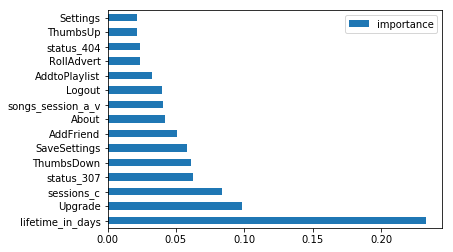

In [59]:
#plot as barh ,take importance as x and features as y
feat_imp.iloc[:15,:].plot(kind='barh');
plt.xlabel = 'Feature Importances by RFClassifier'

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [ ]:
#The reason for continuing the project here is I got, "java.lang.OutOfMemoryError: no enough memory for aggregation",I searched
#in google browser worried about the error , I have taken this extra notebook and continued the project here.